# Read Dataset

In [1]:
import numpy as np
import pandas as pd
import os

pd.options.mode.chained_assignment = None  # default='warn'

# read dataset
data = pd.read_parquet("../data/dataset/shs100k2/data.parquet")[
    ['set_id', 'ver_id', 'yt_id', 'title', 'performer', 'split', 'part',
       'video_title', 'viewcount', 'human_annotated']
]
data = data.explode("title").explode("performer")
data.title = data.title.str.lower()


# Load prepared Wikidata or process Dump

In [2]:
if not os.path.isfile("../data/intermediate/wikidata.parquet"):

    def preprocess_dump(data: pd.DataFrame) -> pd.DataFrame:
        # basic preprocessing
        def get_english_name_or_first(label_dict):
            en_name = label_dict.get("en")
            if en_name:
                name = en_name.get("value").lower()
            else:
                other_names = list(label_dict.values())
                if len(other_names) > 0:
                    name = list(label_dict.values())[0]["value"]
                else:
                    name = ""
            return name
        data["name"] = data.labels.apply(get_english_name_or_first)
        data["nsitelinks"] = data.sitelinks.apply(len)
        data = data[["id", "name", "nsitelinks"]]
        return data    

    # groups
    data_groups = pd.read_json("/data/groups.ndjson", lines=True)
    data_groups = preprocess_dump(data_groups)
    data_groups["type"] = "Group"

    # humans
    data_solo = pd.read_json("/data/soloartists.ndjson", lines=True)
    data_solo = preprocess_dump(data_solo)
    data_solo["type"] = "Human"

    # works
    data_works = pd.read_json("/data/works.ndjson", lines=True).dropna(subset="labels")
    data_works = preprocess_dump(data_works)
    data_works["type"] = "Work"

    data_wikidata = pd.concat([data_groups, data_solo, data_works], axis=0, ignore_index=True).drop_duplicates(subset="id")
    data_wikidata.to_parquet("../data/intermediate/wikidata.parquet")
else:

    data_wikidata = pd.read_parquet("../data/intermediate/wikidata.parquet")

if not "exposure" in data_wikidata.columns:
    def compute_exposure(data: pd.DataFrame) -> pd.DataFrame:
        # rank
        def get_rank(data: pd.DataFrame, column: str) -> pd.Series:
            data = data.sort_values(by=column, ascending=False)
            ranks = data[column].rank(method='min', ascending=False)
            return ranks
        data["rank"] = get_rank(data, "nsitelinks")

        #  exposure

        def exposure(rank, S):
            return np.log(S) - np.log(rank)
        data["exposure"] = data["rank"].apply(lambda x: exposure(x, len(data)))

        return data

    data_wikidata = compute_exposure(data_wikidata)


# Analysis

In [3]:
data_wikidata.type.value_counts()

type
Human    362406
Work     323348
Group    105704
Name: count, dtype: int64

In [4]:
data_wikidata.sort_values(by="nsitelinks", ascending=False).head(10)


,id,name,nsitelinks,type,rank,exposure
290297,Q1177254,david woodard,319,Human,1.0,13.581632
422959,Q2831,michael jackson,310,Human,2.0,12.888485
377075,Q762,leonardo da vinci,297,Human,3.0,12.483020
196207,Q5879,johann wolfgang von goethe,267,Human,4.0,12.195338
377073,Q255,ludwig van beethoven,259,Human,5.0,11.972194
331657,Q254,wolfgang amadeus mozart,259,Human,5.0,11.972194
286393,Q1339,johann sebastian bach,250,Human,7.0,11.635722
196199,Q882,charlie chaplin,247,Human,8.0,11.502191
331682,Q9358,friedrich nietzsche,242,Human,9.0,11.384408
105733,Q9554,martin luther,240,Human,10.0,11.279047


/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


(0.0, 50.0)

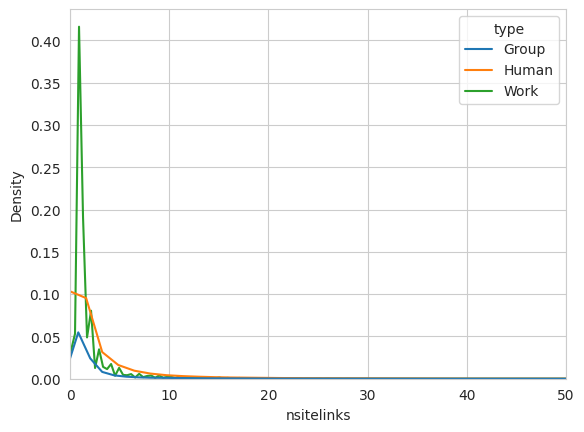

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.kdeplot(data_wikidata, x="nsitelinks", hue="type")
plt.xlim(0,50)


# Merge 

In [6]:
data_artists = pd.merge(
        data, 
        data_wikidata.loc[data_wikidata.type.isin(["Group", "Human"])].add_suffix("_wd"), 
        left_on="performer", right_on="name_wd", how="left")

id_cols = ['set_id', 'ver_id', 'yt_id', 'title', 'performer', 'split', 'part', 'human_annotated']
agg_cols = ['id_wd', 'name_wd', 'nsitelinks_wd', 'type_wd', 'rank_wd', 'exposure_wd']


data_artists = data_artists[id_cols+agg_cols].groupby(id_cols, as_index=False).agg(
    {'id_wd': lambda x: list(x), 'type_wd': lambda x: list(x), 
     'nsitelinks_wd': ["min", "median", "max"], 
      'rank_wd': ["min", "median", "max"], 'exposure_wd': ["min", "median", "max"]})

n=5
mask_na = data_artists[('nsitelinks_wd', 'max')].isna()
print(f"{len(data_artists[mask_na])} not matched")
print(f"{n} random non-matched artists:")
data_artists.loc[mask_na].sample(n).performer.to_list()


45616 not matched
5 random non-matched artists:


['bobby johnson',
 'stanley clarke band',
 'barbra zinger',
 'brian setzer orchestra',
 'man seezer']

In [7]:
data_works = pd.merge(
    data,
    data_wikidata.loc[data_wikidata.type == "Work"].add_suffix("_wd"),
    left_on="title", right_on="name_wd", how="left")

id_cols = ['set_id', 'ver_id', 'yt_id', 'title', 'performer', 'split', 'part', 'human_annotated']
agg_cols = ['id_wd', 'nsitelinks_wd', 'type_wd', 'rank_wd', 'exposure_wd']

data_works = data_works[id_cols+agg_cols].groupby(id_cols, as_index=False).agg(
    {'id_wd': lambda x: list(x), 'type_wd': lambda x: list(x), 
     'nsitelinks_wd': ["min", "median", "max"], 
      'rank_wd': ["min", "median", "max"], 'exposure_wd': ["min", "median", "max"]})

n=5
mask_na = data_works[("exposure_wd", "max")].isna()
print(f"{len(data_works[mask_na])} not matched")
print(f"{n} random non-matched works:")
data_works.loc[mask_na].sample(n).title.to_list()



72317 not matched
5 random non-matched works:


[' [fujiyama mama]',
 'one sweet letter from you',
 'living on a prayer',
 "hab' ich das recht",
 'love will tear us apart']

In [8]:

__artists = data_artists[["set_id", "yt_id", "performer", "nsitelinks_wd", "exposure_wd"]].dropna().drop_duplicates()
wd_cols = ["set_id", "yt_id", "name", "sitelinks_min", "sitelinks_median", "sitelinks_max", "exposure_min", "exposure_median", "exposure_max"]
__artists.columns = wd_cols
__artists["Entity"] = "Artist"

__works = data_works[["set_id", "yt_id", "title", "nsitelinks_wd", "exposure_wd"]].dropna().drop_duplicates()
__works.columns = wd_cols
__works["Entity"] = "WoA"

data_merged = pd.concat([__artists, __works])
data_merged = data_merged.groupby(
    ["set_id", "name", "Entity", "sitelinks_min", "sitelinks_median", "sitelinks_max", "exposure_min", 
     "exposure_median", "exposure_max"], as_index=False).agg(list)
data_merged.to_json("../data/intermediate/shs100k2_exposure.json", lines=True, orient="records")


/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


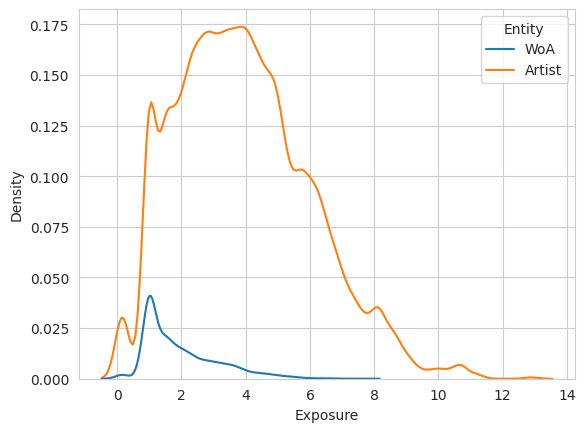

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(data_merged, x="exposure_max", hue="Entity")
plt.xlabel("Exposure")
plt.savefig("../figures/kde_exposure.pdf")
plt.show()


In [10]:
our_artists = data_merged.loc[data_merged.Entity == "Artist"].name.to_list()
our_woas = data_merged.loc[data_merged.Entity == "WoA"].name.to_list()


# Check overlap with MuscRecoNER

### Load MusicRecoNER

In [11]:
import pandas as pd

data_reconer = pd.DataFrame()

for i in range(1, 5):
    __data = pd.read_csv(f"../baseline/music-ner-eacl2023/data/dataset{i}/ground-truth_linked.csv")
    __data["subset"] = f"dataset{i}"
    data_reconer = pd.concat([data_reconer, __data])


In [12]:
import sys
sys.path.append("..")
from preprocessing.Utils import remove_brackets_and_all_content

data_reconer["wiki_name_normalized"] = data_reconer.wiki_name.str.lower().str.replace("_", " ").apply(
    lambda x: remove_brackets_and_all_content(x) if isinstance(x, str) else x)


# Stratified Joint Datasets --> Reddit+SHS-YT

In [13]:
mapping = data_merged[["Entity", "name", "set_id"]].set_index(["Entity", "name"]).to_dict()["set_id"]

# add our set_id
data_reconer["set_id"] = data_reconer.apply(lambda x: mapping.get((x.type, x.wiki_name_normalized)), axis=1)
data_reconer["set_id"].notna().value_counts()


set_id
False    1860
True      338
Name: count, dtype: int64

In [14]:
from src.Utils import read_IOB_file

def get_music_reconer(path: str = "../data/dataset/reddit"):
    data = pd.DataFrame()
    for i in range(1, 5):
        words, tags = read_IOB_file(os.path.join(path, f"dataset{i}/test.IOB"))
        __data = pd.DataFrame()
        __data["query"] = [' '.join(ws) for ws in words]
        __data["IOB"] = tags
        __data["dataset"] = f"dataset{i}"
        __data["idx"] = [i for i in range(len(__data))]

        data = pd.concat([data, __data])
    return data

data_reconer = pd.merge(get_music_reconer(), data_reconer, on="query", how="left")
data_reconer["TEXT"] = data_reconer["query"].str.split()
data_reconer["id"] = data_reconer.apply(lambda x: x.dataset + '_' + str(x.idx), axis=1)
data_reconer["Origin"] = "Reddit"


In [15]:
data_ours = pd.read_parquet("../data/dataset/shs100k2/data.parquet").query("human_annotated")
data_ours["id"] = data_ours.apply(lambda x: str(x.set_id) + '_' + x.yt_id, axis=1)
data_ours["Origin"] = "YouTube"


In [16]:
data_joint = pd.concat([
    data_ours[["id", "set_id", "Origin", "TEXT", "IOB"]],
    data_reconer[["id", "set_id", "Origin", "TEXT", "IOB"]]
    ])


In [17]:
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupKFold

def kfold(data: pd.DataFrame, k: int = 5, stratify_origin: bool = True) -> pd.DataFrame:

    def fillna_unique(series: pd.Series) -> pd.Series:
        dummies = series.index + series.max()
        mask = series.isna()
        series.loc[mask] = dummies.values[mask]
        return series

    # Origin
    y = (data.Origin == "YouTube").values.astype(int)

    # Class ID
    groups = fillna_unique(data.set_id).values
    X = data.index

    if stratify_origin:
        kfs = StratifiedGroupKFold(n_splits=k)
    else:
        kfs = GroupKFold(n_splits=k)

    data["subset"] = None
    for i, (train_index, test_index) in enumerate(kfs.split(X, y, groups)):
        print(f"Fold {i}:")
        overlap = np.intersect1d(groups[train_index], groups[test_index])
        print(f"Overlap in Groups: {len(overlap) > 0}")
        print("train size", len(groups[train_index]))
        print("test size", len(groups[test_index]))
        data.iloc[test_index, data.columns.get_loc("subset")] = i + 1
    return data

data_joint = kfold(data_joint, stratify_origin=True)


Fold 0:
Overlap in Groups: False
train size 2634
test size 660
Fold 1:
Overlap in Groups: False
train size 2634
test size 660
Fold 2:
Overlap in Groups: False
train size 2636
test size 658
Fold 3:
Overlap in Groups: False
train size 2636
test size 658
Fold 4:
Overlap in Groups: False
train size 2636
test size 658


# Write Reddit+SHSYT dataset

In [18]:
import os
from preprocessing.Utils import write_biotag

base_path = "../data/dataset/reddit+shsyt"

for i in data_joint.subset.unique():
    subset_path = os.path.join(base_path, f"dataset{i}")
    os.makedirs(subset_path, exist_ok=True)
    write_biotag(data_joint.loc[data_joint.subset == i], os.path.join(subset_path, "test.IOB"), "IOB")
    write_biotag(data_joint.loc[data_joint.subset != i], os.path.join(subset_path, "train.IOB"), "IOB")

data_joint.to_parquet("../data/dataset/reddit+shsyt/data.parquet")


In [19]:
data = data_joint.loc[data_joint.Origin == "YouTube"]
data = kfold(data, k=5, stratify_origin=False)

base_path = "../data/dataset/shsyt/"    
os.makedirs(base_path, exist_ok=True)

for i in data_joint.subset.unique():
    subset_path = os.path.join(base_path, f"dataset{i}")
    os.makedirs(subset_path, exist_ok=True)
    write_biotag(data.loc[data.subset == i], os.path.join(subset_path, "test.IOB"), "IOB")
    write_biotag(data.loc[data.subset != i], os.path.join(subset_path, "train.IOB"), "IOB")

data.to_parquet(os.path.join(base_path, "data.parquet"))


Fold 0:
Overlap in Groups: False
train size 490
test size 123
Fold 1:
Overlap in Groups: False
train size 490
test size 123
Fold 2:
Overlap in Groups: False
train size 490
test size 123
Fold 3:
Overlap in Groups: False
train size 491
test size 122
Fold 4:
Overlap in Groups: False
train size 491
test size 122


In [20]:
kfold(data, stratify_origin=True)


Fold 0:
Overlap in Groups: False
train size 490
test size 123
Fold 1:
Overlap in Groups: False
train size 490
test size 123
Fold 2:
Overlap in Groups: False
train size 490
test size 123
Fold 3:
Overlap in Groups: False
train size 491
test size 122
Fold 4:
Overlap in Groups: False
train size 491
test size 122


,id,set_id,Origin,TEXT,IOB,subset
46,21_L1-t3YvFH40,21.0,YouTube,"[gladys, knight, &, the, pips, -, yesterday]","[B-Artist, I-Artist, O, B-Artist, I-Artist, O,...",4
79,21_4SE8UvqaSWQ,21.0,YouTube,"[hooked, on, the, beatles, -, the, end]","[B-WoA, I-WoA, I-WoA, I-WoA, O, B-WoA, I-WoA]",4
170,58_hQz-aZH-ozU,58.0,YouTube,"[juan, rozoff, -, plaisir, d, amour]","[B-Artist, I-Artist, O, B-WoA, I-WoA, I-WoA]",2
219,58_Ajp0Uaw4rqo,58.0,YouTube,"[ub40, cant, help, falling, in, love]","[B-Artist, B-WoA, I-WoA, I-WoA, I-WoA, I-WoA]",2
224,58_m3MXZ_qdKDU,58.0,YouTube,"[pearl, jam, -, i, cant, help, falling, in, lo...","[B-Artist, I-Artist, O, B-WoA, I-WoA, I-WoA, I...",2
...,...,...,...,...,...,...
105792,5559_89C_PQ_kuUk,5559.0,YouTube,"[the, bootleggers, feat, mark, lanegan, -, whi...","[B-Artist, I-Artist, O, B-Artist, I-Artist, O,...",4
105973,5584_HjvkJTLdR28,5584.0,YouTube,"[sweet, inspiration, by, the, sweet, inspirati...","[B-WoA, I-WoA, O, B-Artist, B-Artist, I-Artist]",2
106425,5652_TVH2IIWRMoY,5652.0,YouTube,"[wilson, pickett, ninty, nine, a, half, ., wmv]","[B-Artist, I-Artist, B-WoA, I-WoA, I-WoA, I-Wo...",3
106806,5718_iUpwTwYznO0,5718.0,YouTube,"[disney, adventures, in, samba, -, aqui, no, m...","[B-WoA, I-WoA, I-WoA, I-WoA, O, B-WoA, I-WoA, ...",5
